In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from skbio.stats.composition import clr, centralize, alr_inv
from skbio.stats.composition import clr_inv as softmax
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator

from src.generators import ground_truth_edges
from src.evaluate import _edge_roc_curve
from biom import load_table
from scipy.stats import spearmanr, pearsonr
import glob
#import yaml
import datetime
%matplotlib inline

# CF simulation benchmark

In [2]:
results_dir = './results/CF_sims/'
microbes = load_table(os.path.join(results_dir, 'data/table.abs.microbes.0.biom'))
metabolites = load_table(os.path.join(results_dir, 'data/table.abs.metabolites.0.biom'))

In [3]:
mmvec_dir = 'abs/mmvec/'
U = np.loadtxt(os.path.join(results_dir, mmvec_dir + 'U.txt'))
Ubias = np.loadtxt(os.path.join(results_dir, mmvec_dir + 'Ubias.txt'))
V = np.loadtxt(os.path.join(results_dir, mmvec_dir + 'V.txt'))
Vbias = np.loadtxt(os.path.join(results_dir, mmvec_dir + 'Vbias.txt'))

U = np.hstack((np.ones((U.shape[0], 1)), Ubias.reshape(-1, 1), U))
V = np.vstack((Vbias, np.ones((1, V.shape[1])), V))
abs_ranks = pd.DataFrame(clr(alr_inv(U @ V)), index=microbes.ids(axis='observation'),
                         columns=metabolites.ids(axis='observation'))

In [4]:
mmvec_dir = 'rel/mmvec/'
U = np.loadtxt(os.path.join(results_dir, mmvec_dir + 'U.txt'))
Ubias = np.loadtxt(os.path.join(results_dir, mmvec_dir + 'Ubias.txt'))
V = np.loadtxt(os.path.join(results_dir, mmvec_dir + 'V.txt'))
Vbias = np.loadtxt(os.path.join(results_dir, mmvec_dir + 'Vbias.txt'))

U = np.hstack((np.ones((U.shape[0], 1)), Ubias.reshape(-1, 1), U))
V = np.vstack((Vbias, np.ones((1, V.shape[1])), V))
rel_ranks = pd.DataFrame(clr(alr_inv(U @ V)), index=microbes.ids(axis='observation'),
                         columns=metabolites.ids(axis='observation'))
rel_ranks.to_csv("../rel_ranks_mmvec.tsv", sep='\t', index=True)


In [5]:
# create separate ROC curves for each type of interaction
released = [('theta_p', 'I'),
            ('theta_p', 'P'),
            ('theta_f', 'F')]
consumed = [('theta_p', 'SA'),
            ('theta_f', 'SG')]
inhibited = [('theta_f', 'I')]

In [6]:
sensitivity = lambda x: x['TP'] / (x['TP'] + x['FN'])
specificity = lambda x: x['TN'] / (x['TN'] + x['FP'])
precision = lambda x: x['TP'] / (x['TP'] + x['FP'])
recall = lambda x: x['TP'] / (x['TP'] + x['FN'])

In [7]:
#results_dir = '../results/benchmark_output/scale_benchmark/'
#microbes = load_table(os.path.join(results_dir, 'microbe_abs.biom'))
#metabolites = load_table(os.path.join(results_dir, 'metabolite_abs.biom'))

fnames = [
    ['pearson', 'abs_pearson.txt', 'rel_pearson.txt'],
    ['spearman', 'abs_spearman.txt', 'rel_spearman.txt'],
    ['sparcc', 'cor_matrix_abs_SparCC.csv', 'cor_matrix_rel_SparCC.csv'],
    ['phi', 'prop_matrix_abs_PHI.csv', 'prop_matrix_rel_PHI.csv'],
    ['rho', 'prop_matrix_abs_RHO.csv', 'prop_matrix_rel_RHO.csv'],
    ['spiec-easi', 'weights_abs_SPIECEASI.csv', 'weights_rel_SPIECEASI.csv']
]

In [8]:
def plot_scales(tool, abs_file, rel_file, axs):
    microbe_ids = microbes.ids(axis='observation')
    metabolite_ids = metabolites.ids(axis='observation')
    lw = 0.1
    if '.txt' in abs_file or '.txt' in rel_file:
        abs_ranks = pd.read_table(os.path.join(results_dir, 'abs/' + abs_file),
                                  index_col=0).loc[microbe_ids, metabolite_ids]
        rel_ranks = pd.read_table(os.path.join(results_dir, 'rel/' + rel_file),
                                  index_col=0).loc[microbe_ids, metabolite_ids]
    else:
        abs_ranks = pd.read_csv(os.path.join(results_dir, 'abs/' + abs_file),
                                index_col=0).loc[microbe_ids, metabolite_ids]
        rel_ranks = pd.read_csv(os.path.join(results_dir, 'rel/' + rel_file),
                                index_col=0).loc[microbe_ids, metabolite_ids]

    axs.scatter(abs_ranks.values.ravel(), rel_ranks.values.ravel(), linewidth=lw,
                facecolors='none', edgecolors='k', alpha=0.5)

    axs.tick_params(axis="x", labelsize=14)
    axs.tick_params(axis="y", labelsize=14)
    axs.xaxis.set_major_locator(plt.MaxNLocator(4))
    axs.yaxis.set_major_locator(plt.MaxNLocator(4))
    axs.set_title(tool, fontsize=18)
    axs.set_xlabel('Absolute', fontsize=14)
    axs.set_ylabel('Relative', fontsize=14)

Text(0, 0.5, 'Relative')

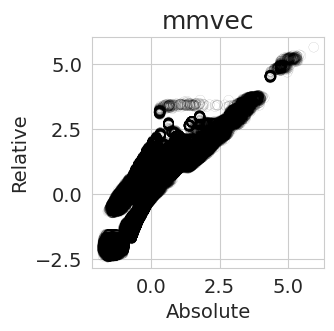

In [10]:
tool = 'mmvec'
fig, axs = plt.subplots(figsize=(3, 3))
axs.scatter(abs_ranks.values.ravel(), rel_ranks.values.ravel(), linewidth=0.1,
            facecolors='none', edgecolors='k', alpha=0.5, s=50)

axs.tick_params(axis="x", labelsize=14)
axs.tick_params(axis="y", labelsize=14)
axs.xaxis.set_major_locator(plt.MaxNLocator(4))
axs.yaxis.set_major_locator(plt.MaxNLocator(4))
axs.set_title(tool, fontsize=18)
axs.set_xlabel('Absolute', fontsize=14)
axs.set_ylabel('Relative', fontsize=14)

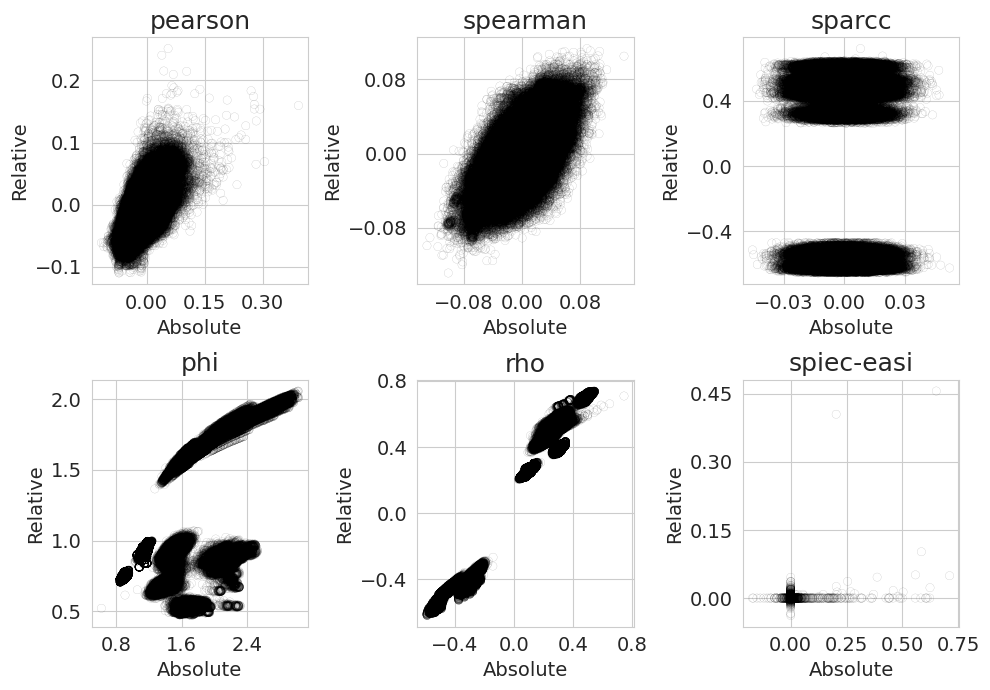

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(10, 7))
for idx, res in enumerate(fnames):
    t, a, r = res
    i, j = idx // 3, idx % 3
    plot_scales(t, a, r, ax[i][j])

plt.tight_layout()

Text(0, 0.5, 'Relative')

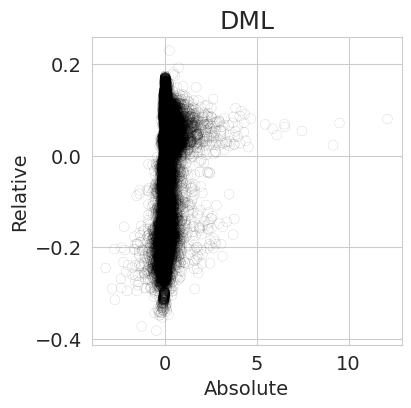

In [9]:
ranks = rel_ranks
dml_abs_ranks = pd.read_csv(os.path.join(results_dir, 'abs/dml_ranks.norm.tsv'), index_col=0, sep="\t").T.loc[
    ranks.index, ranks.columns]
dml_rel_ranks = pd.read_csv(os.path.join(results_dir, 'rel/dml_ranks.norm.tsv'), index_col=0, sep="\t").T.loc[
    ranks.index, ranks.columns]

tool = 'DML'
fig, axs = plt.subplots(figsize=(4, 4))
axs.scatter(dml_abs_ranks.values.ravel(), dml_rel_ranks.values.ravel(), linewidth=0.1,
            facecolors='none', edgecolors='k', alpha=0.5, s=50)

axs.tick_params(axis="x", labelsize=14)
axs.tick_params(axis="y", labelsize=14)
axs.xaxis.set_major_locator(plt.MaxNLocator(4))
axs.yaxis.set_major_locator(plt.MaxNLocator(4))
axs.set_title(tool, fontsize=18)
axs.set_xlabel('Absolute', fontsize=14)
axs.set_ylabel('Relative', fontsize=14)

# Precision-Recall curves

In [9]:
ranks = rel_ranks
pearson_ranks = pd.read_table(os.path.join(results_dir, 'rel/rel_pearson.txt'), index_col=0)
spearman_ranks = pd.read_table(os.path.join(results_dir, 'rel/rel_spearman.txt'), index_col=0)
sparcc_ranks = pd.read_csv(os.path.join(results_dir, 'rel/cor_matrix_rel_SparCC.csv'),
                           index_col=0).loc[ranks.index, ranks.columns]
phi_ranks = pd.read_csv(os.path.join(results_dir, 'rel/prop_matrix_rel_PHI.csv'),
                        index_col=0).loc[ranks.index, ranks.columns]
rho_ranks = pd.read_csv(os.path.join(results_dir, 'rel/prop_matrix_rel_RHO.csv'),
                        index_col=0).loc[ranks.index, ranks.columns]
se_ranks = pd.read_csv(os.path.join(results_dir, 'rel/weights_rel_SPIECEASI.csv'),
                       index_col=0).loc[ranks.index, ranks.columns]

# Read DML ranks
dml_results_dir = './results/DML/'

dml_ranks_rf = pd.read_csv(os.path.join(dml_results_dir, 'original_data/coefficients.tsv'), index_col=0, sep="\t").T.loc[
    ranks.index, ranks.columns]
# dml_ranks_lr = pd.read_csv(os.path.join(dml_results_dir, 'rel/dml_ranks.lr.tsv'), index_col=0, sep="\t").T.loc[
#     ranks.index, ranks.columns]
# dml_ranks_boost = pd.read_csv(os.path.join(dml_results_dir, 'rel/dml_ranks.boost.earlystopping.tsv'), index_col=0, sep="\t").T.loc[
#     ranks.index, ranks.columns]
# dml_ranks_norm = pd.read_csv(os.path.join(dml_results_dir, 'rel/dml_ranks.norm.tsv'), index_col=0, sep="\t").T.loc[
#     ranks.index, ranks.columns]
# dml_ranks_clr_rf = pd.read_csv(os.path.join(dml_results_dir, 'rel/dml_ranks_clr_rf.tsv'), index_col=0, sep="\t").T.loc[
#     ranks.index, ranks.columns]
# dml_ranks_clr_scaled_rf = pd.read_csv(os.path.join(dml_results_dir, 'rel/dml_ranks.clr_scaled.tsv'), index_col=0, sep="\t").T.loc[
#     ranks.index, ranks.columns]
# dml_ranks_clr_min_rf = pd.read_csv(os.path.join(dml_results_dir, 'rel/dml_ranks.clr_min.tsv'), index_col=0, sep="\t").T.loc[
#     ranks.index, ranks.columns]
# dml_ranks_clr_sc_min_rf = pd.read_csv(os.path.join(dml_results_dir, 'rel/dml_ranks.clr_sc_min.tsv'), index_col=0, sep="\t").T.loc[
#     ranks.index, ranks.columns]
# dml_ranks_clr_sep_rf = pd.read_csv(os.path.join(dml_results_dir, 'rel/dml_ranks.clr_sep.tsv'), index_col=0, sep="\t").T.loc[
#     ranks.index, ranks.columns]
# dml_ranks_clr_sep_min_rf = pd.read_csv(os.path.join(dml_results_dir, 'rel/dml_ranks.clr_sep_min.tsv'), index_col=0, sep="\t").T.loc[
#     ranks.index, ranks.columns]

# dml_subset20 = pd.read_csv(os.path.join(dml_results_dir, 'rel/subset20/coefficient_matrix_parallel.tsv'), index_col=0, sep="\t").T.loc[ranks.index, ranks.columns]
# dml_subset100 = pd.read_csv(os.path.join(dml_results_dir, 'rel/subset100/coefficient_matrix_parallel.tsv'), index_col=0, sep="\t").T.loc[ranks.index, ranks.columns]
# dml_subset500 = pd.read_csv(os.path.join(dml_results_dir, 'rel/subset500/coefficient_matrix_parallel.tsv'), index_col=0, sep="\t").T.loc[ranks.index, ranks.columns]

In [10]:
edges = pd.read_table(os.path.join(results_dir, 'data/edges.0.txt'), index_col=0)

/tmp/ipykernel_8911/3109896698.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  edges = pd.read_table(os.path.join(results_dir, 'data/edges.0.txt'), index_col=0)


In [11]:
edges.head()

,microbe,metabolite,direction
0,theta_p_0,P_0,R
1,theta_p_0,P_1,R
2,theta_p_0,P_2,R
3,theta_p_0,P_3,R
4,theta_p_0,P_4,R


In [12]:
k = 100
mmvec_res = _edge_roc_curve(ranks, edges, k_max=k, axis=1)
# pearson_res = _edge_roc_curve(pearson_ranks, edges, k_max=k, axis=1)
# spearman_res = _edge_roc_curve(spearman_ranks, edges, k_max=k, axis=1)
# sparcc_res = _edge_roc_curve(sparcc_ranks, edges, k_max=k, axis=1)
# phi_res = _edge_roc_curve(1 / phi_ranks, edges, k_max=k, axis=1)
# rho_res = _edge_roc_curve(rho_ranks, edges, k_max=k, axis=1)
# se_res = _edge_roc_curve(se_ranks, edges, k_max=k, axis=1)

dml_rf = _edge_roc_curve(dml_ranks_rf, edges, k_max=k, axis=1)
# dml_lr = _edge_roc_curve(dml_ranks_lr, edges, k_max=k, axis=1)
# dml_boost = _edge_roc_curve(dml_ranks_boost, edges, k_max=k, axis=1)
# dml_norm_res = _edge_roc_curve(dml_ranks_norm, edges, k_max=k, axis=1)
# dml_clr_rf_res = _edge_roc_curve(dml_ranks_clr_rf, edges, k_max=k, axis=1)
# dml_clr_scaled_rf_res = _edge_roc_curve(dml_ranks_clr_scaled_rf, edges, k_max=k, axis=1)
# dml_clr_min_rf_res = _edge_roc_curve(dml_ranks_clr_min_rf, edges, k_max=k, axis=1)
# dml_clr_sc_min_rf_res = _edge_roc_curve(dml_ranks_clr_sc_min_rf, edges, k_max=k, axis=1)
# dml_clr_sep_rf_res = _edge_roc_curve(dml_ranks_clr_sep_rf, edges, k_max=k, axis=1)
# dml_clr_sep_min_rf_res = _edge_roc_curve(dml_ranks_clr_sep_min_rf, edges, k_max=k, axis=1)
# subset20_res = _edge_roc_curve(dml_subset20, edges, k_max=k, axis=1)
# subset100_res = _edge_roc_curve(dml_subset100, edges, k_max=k, axis=1)
# subset500_res = _edge_roc_curve(dml_subset500, edges, k_max=k, axis=1)

In [13]:
sensitivity = lambda x: x['TP'] / (x['TP'] + x['FN'])
specificity = lambda x: x['TN'] / (x['TN'] + x['FP'])
precision = lambda x: x['TP'] / (x['TP'] + x['FP'])
recall = lambda x: x['TP'] / (x['TP'] + x['FN'])
f1 = lambda x: 2 * x['precision'] * x['recall'] / (x['precision'] + x['recall'])

In [14]:
for res in (mmvec_res,
            # pearson_res, spearman_res, sparcc_res, phi_res, rho_res, se_res,
            # dml_rf, dml_norm_res, subset20_res, subset100_res, subset500_res,
            dml_rf,
            # dml_lr, dml_boost,
            # dml_clr_rf_res, dml_clr_scaled_rf_res, dml_clr_sep_rf_res, dml_clr_min_rf_res, dml_clr_sc_min_rf_res, dml_clr_sep_min_rf_res
            ):
    for df in res:
        df['TPR'] = df.apply(sensitivity, axis=1)
        df['TNR'] = df.apply(specificity, axis=1)
        df['precision'] = df.apply(precision, axis=1)
        df['recall'] = df.apply(recall, axis=1)
        df['f1_score'] = df.apply(f1, axis=1)

/tmp/ipykernel_8911/1052544215.py:5: RuntimeWarning: invalid value encountered in double_scalars
  f1 = lambda x: 2 * x['precision'] * x['recall'] / (x['precision'] + x['recall'])
/tmp/ipykernel_8911/1052544215.py:5: RuntimeWarning: invalid value encountered in double_scalars
  f1 = lambda x: 2 * x['precision'] * x['recall'] / (x['precision'] + x['recall'])
/tmp/ipykernel_8911/1052544215.py:5: RuntimeWarning: invalid value encountered in double_scalars
  f1 = lambda x: 2 * x['precision'] * x['recall'] / (x['precision'] + x['recall'])


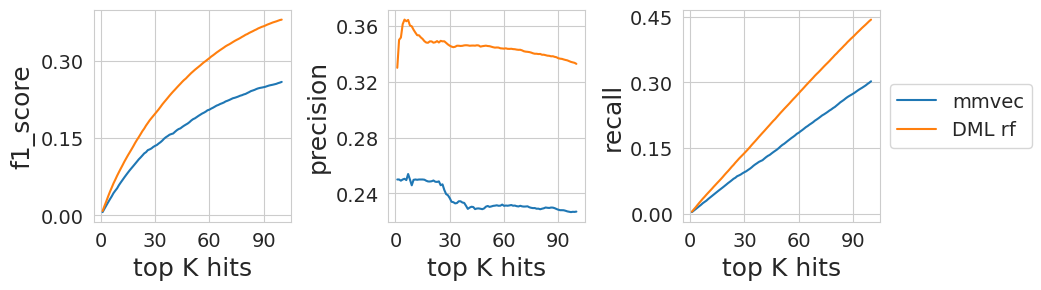

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

edge_dir = 0 # for released
# edge_dir = 1  # for consumed


# edge_dir = 2 # for inhibited

def plot_stats(ax, attr='F score', edge_dir=0):
    ax.plot(mmvec_res[edge_dir][attr], label='mmvec')
    # ax.plot(pearson_res[edge_dir][attr], label='spearman')
    # ax.plot(spearman_res[edge_dir][attr], label='pearson')
    # ax.plot(sparcc_res[edge_dir][attr], label='sparcc')
    # ax.plot(phi_res[edge_dir][attr], label='phi')
    # ax.plot(rho_res[edge_dir][attr], label='rho')
    # ax.plot(se_res[edge_dir][attr], label='spiec-easi')

    ax.plot(dml_rf[edge_dir][attr], label='DML rf')
    # ax.plot(dml_norm_res[edge_dir][attr], label='DML norm')
    # ax.plot(dml_clr_rf_res[edge_dir][attr], label='DML clr')
    # ax.plot(dml_clr_scaled_rf_res[edge_dir][attr], label='DML clr (sc)')
    # ax.plot(dml_clr_min_rf_res[edge_dir][attr], label='DML clr (min)')
    # ax.plot(dml_clr_sc_min_rf_res[edge_dir][attr], label='DML clr (sc min)')
    # ax.plot(dml_clr_sep_rf_res[edge_dir][attr], label='DML clr (sep)')
    # ax.plot(dml_clr_sep_min_rf_res[edge_dir][attr], label='DML clr (sep min)')
    # ax.plot(subset20_res[edge_dir][attr], label='DML subset20')
    # ax.plot(subset100_res[edge_dir][attr], label='DML subset100')
    # ax.plot(subset500_res[edge_dir][attr], label='DML subset500')
    # ax.plot(subset500_res[edge_dir][attr], label='DML subset500')
    # ax.plot(dml_lr[edge_dir][attr], label='DML lr')
    # ax.plot(dml_boost[edge_dir][attr], label='DML boost')
    ax.set_ylabel(attr, fontsize=18)
    ax.set_xlabel('top K hits', fontsize=18)
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))


plot_stats(ax[0], attr='f1_score', edge_dir=edge_dir)
plot_stats(ax[1], attr='precision', edge_dir=edge_dir)
plot_stats(ax[2], attr='recall', edge_dir=edge_dir)
plt.tight_layout()
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
plt.savefig(f"./figures/sim_{timestamp}.png", bbox_inches='tight')

In [21]:
dml_rf[0]

,TP,TN,FP,FN,TPR,TNR,precision,recall,f1_score
1,152,249752,248,29848,0.005067,0.999008,0.380000,0.005067,0.010000
2,314,249514,486,29686,0.010467,0.998056,0.392500,0.010467,0.020390
3,469,249269,731,29531,0.015633,0.997076,0.390833,0.015633,0.030064
4,626,249026,974,29374,0.020867,0.996104,0.391250,0.020867,0.039620
5,777,248777,1223,29223,0.025900,0.995108,0.388500,0.025900,0.048563
...,...,...,...,...,...,...,...,...,...
96,13345,224945,25055,16655,0.444833,0.899780,0.347526,0.444833,0.390205
97,13460,224660,25340,16540,0.448667,0.898640,0.346907,0.448667,0.391279
98,13569,224369,25631,16431,0.452300,0.897476,0.346148,0.452300,0.392168
99,13670,224070,25930,16330,0.455667,0.896280,0.345202,0.455667,0.392816


In [21]:
dml_rf[1]

,TP,TN,FP,FN,TPR,TNR,precision,recall,f1_score
1,6,259606,394,19994,0.00030,0.998485,0.015000,0.00030,0.000588
2,12,259212,788,19988,0.00060,0.996969,0.015000,0.00060,0.001154
3,17,258817,1183,19983,0.00085,0.995450,0.014167,0.00085,0.001604
4,20,258420,1580,19980,0.00100,0.993923,0.012500,0.00100,0.001852
5,26,258026,1974,19974,0.00130,0.992408,0.013000,0.00130,0.002364
...,...,...,...,...,...,...,...,...,...
96,334,221934,38066,19666,0.01670,0.853592,0.008698,0.01670,0.011438
97,336,221536,38464,19664,0.01680,0.852062,0.008660,0.01680,0.011429
98,340,221140,38860,19660,0.01700,0.850538,0.008673,0.01700,0.011486
99,344,220744,39256,19656,0.01720,0.849015,0.008687,0.01720,0.011544


In [15]:
dml_ranks

,P_0,P_1,P_2,P_3,P_4,P_5,P_6,P_7,P_8,P_9,...,noise_ms_190,noise_ms_191,noise_ms_192,noise_ms_193,noise_ms_194,noise_ms_195,noise_ms_196,noise_ms_197,noise_ms_198,noise_ms_199
theta_p_0,-2435.990741,-740.883383,-1460.921355,-638.771452,-386.623534,-439.459447,-1507.993856,-369.166568,-549.803102,-1150.993404,...,1.148162,-9.251800,-13.635029,-8.944870,-25.511678,4.813060,-20.087902,-25.051825,-2.271995,-6.439077
theta_p_1,-1214.347304,-358.800873,-945.111416,-409.028914,-169.132390,-539.992511,-1068.729762,-281.519090,-387.992800,-675.817247,...,-13.369348,-15.616567,-20.495306,-21.018418,-2.973748,-2.580308,-19.587463,-22.384377,-13.746672,-34.105881
theta_p_2,205.429282,2934.324900,234.854744,1496.972535,792.417640,-966.146207,898.164897,-222.474820,-405.394860,-413.827978,...,-40.505271,8.684965,-2.157691,-19.140397,-25.100309,-35.786898,-17.223260,-42.685623,-24.918484,-13.893307
theta_p_3,-2256.390654,58.303351,-1322.588947,-21.300033,474.560305,-61.416752,-928.873530,502.387989,-429.292587,-584.891283,...,-30.086273,-52.527887,23.757896,-39.236486,-30.704331,-31.063032,-35.245942,4.728239,-35.538959,-38.092064
theta_p_4,-148.114044,-404.034086,1499.599826,-301.195501,224.911506,5588.567447,215.370643,1785.210584,477.707361,346.728114,...,-35.352845,-29.238222,-35.965341,-77.663258,-16.851558,-27.210250,-6.297791,-4.321063,-19.344955,-59.822066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
noise_otu_195,-161760.626773,-30763.855223,-90258.539552,-28320.971361,-18897.814818,-38814.340497,-98623.185052,-18421.268673,-28310.364752,-48718.075736,...,1978.437651,1336.330946,614.412393,1008.979678,1987.419807,1933.471739,3055.876424,3139.743965,1054.868741,2331.906953
noise_otu_196,-55486.558881,-18937.707748,-33304.172865,-18868.471290,-8915.912917,-18743.584991,-36639.579563,-10494.413892,-15529.716625,-30915.010672,...,883.143343,950.940507,266.693377,1865.672342,1933.990276,954.748328,1058.516632,1917.699824,1424.312754,1462.222705
noise_otu_197,-23680.796868,-5678.120161,-9067.643763,-3848.266771,-4147.297940,-10209.255423,-10731.116846,-4079.793866,-2873.462293,-3220.398471,...,562.551162,1601.750092,369.313661,1724.813909,1033.475832,349.638822,637.734260,934.818940,1092.272216,1604.071724
noise_otu_198,-86526.248816,-14734.281769,-47944.750215,-14485.289035,-9610.089136,-19001.069118,-50139.086030,-9230.517200,-16023.968920,-23624.301199,...,2421.487437,671.316412,-323.394941,2529.738664,2553.446500,1043.878549,1794.545584,1445.099033,1253.696467,1567.221282


In [34]:
mmvec_res[1]

,TP,TN,FP,FN,TPR,TNR,precision,recall,f1_score
1,0,259600,400,20000,0.0,0.998462,0.0,0.0,NaN
2,0,259200,800,20000,0.0,0.996923,0.0,0.0,NaN
3,0,258800,1200,20000,0.0,0.995385,0.0,0.0,NaN
4,0,258400,1600,20000,0.0,0.993846,0.0,0.0,NaN
5,0,258000,2000,20000,0.0,0.992308,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...
96,0,221600,38400,20000,0.0,0.852308,0.0,0.0,NaN
97,0,221200,38800,20000,0.0,0.850769,0.0,0.0,NaN
98,0,220800,39200,20000,0.0,0.849231,0.0,0.0,NaN
99,0,220400,39600,20000,0.0,0.847692,0.0,0.0,NaN


In [39]:
sranks = pd.DataFrame(
    list(ranks.apply(
        lambda x: list(ranks.columns[np.argsort(x)]), axis=1)
    )
)
sranks.index = ranks.index

sranks

,0,1,2,3,4,5,6,7,8,9,...,690,691,692,693,694,695,696,697,698,699
theta_p_0,noise_ms_197,noise_ms_171,noise_ms_195,noise_ms_140,noise_ms_185,noise_ms_110,noise_ms_129,noise_ms_134,noise_ms_50,noise_ms_61,...,F_21,F_31,P_0,P_48,F_14,P_14,P_40,F_40,P_19,P_49
theta_p_1,noise_ms_197,noise_ms_20,noise_ms_195,noise_ms_185,noise_ms_140,noise_ms_112,noise_ms_99,noise_ms_32,noise_ms_134,noise_ms_129,...,P_75,F_21,P_0,F_40,F_14,P_48,P_14,P_40,P_19,P_49
theta_p_2,noise_ms_197,noise_ms_195,noise_ms_20,noise_ms_185,noise_ms_129,noise_ms_140,noise_ms_112,noise_ms_171,noise_ms_63,noise_ms_99,...,P_75,F_21,P_0,F_14,P_48,F_40,P_40,P_14,P_19,P_49
theta_p_3,noise_ms_197,noise_ms_195,noise_ms_20,noise_ms_185,noise_ms_129,noise_ms_140,noise_ms_112,noise_ms_99,noise_ms_32,noise_ms_134,...,P_75,F_21,P_0,F_14,P_48,F_40,P_14,P_40,P_19,P_49
theta_p_4,noise_ms_197,noise_ms_195,noise_ms_129,noise_ms_20,noise_ms_185,noise_ms_140,noise_ms_112,noise_ms_63,noise_ms_171,noise_ms_86,...,P_75,F_21,P_0,F_14,P_48,F_40,P_40,P_14,P_19,P_49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
noise_otu_195,noise_ms_197,noise_ms_185,noise_ms_195,noise_ms_99,noise_ms_171,noise_ms_63,noise_ms_137,noise_ms_21,noise_ms_134,noise_ms_140,...,P_75,SG_30,P_0,F_14,P_48,F_40,P_14,P_40,P_19,P_49
noise_otu_196,noise_ms_195,noise_ms_197,noise_ms_185,noise_ms_99,noise_ms_63,noise_ms_171,noise_ms_134,noise_ms_140,noise_ms_21,noise_ms_137,...,SG_30,P_75,F_14,P_48,P_0,F_40,P_14,P_40,P_19,P_49
noise_otu_197,noise_ms_195,noise_ms_185,noise_ms_197,noise_ms_99,noise_ms_63,noise_ms_21,noise_ms_137,noise_ms_134,noise_ms_196,noise_ms_171,...,P_75,SG_30,F_14,P_0,P_48,F_40,P_14,P_40,P_19,P_49
noise_otu_198,noise_ms_197,noise_ms_195,noise_ms_185,noise_ms_171,noise_ms_63,noise_ms_140,noise_ms_134,noise_ms_99,noise_ms_20,noise_ms_196,...,F_31,P_75,F_14,P_48,P_0,F_40,P_40,P_14,P_19,P_49
